# Tarea 1: Algoritmo a priori

IIC2344 - Minería de Datos  
Gregory Schuit

In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import time

### Funciones

In [2]:
def join(C, eliminados):
    """
    input: Diccionario de itemsets como keys, junto con un set de itemsets (tuplas) 
            descartados en iteraciones anteriores.
    output: Lista de itemsets generados listos para ser contados.
    """
    
    print("Executing join...")
    t1 = time.time()
    L_out = []
    total = len(C)
    print('Minutes left: ')
    
    for i, set1 in enumerate(C):
        t2 = time.time()
        vel = (t2 - t1) / (i + 1)
        print('{:.3f}'.format(vel * (total - i) / 60), end='\r')
        
        tupla1 = tuple(sorted(set1))
        
        for set2 in C:
            tupla2 = tuple(sorted(set2))
            
            for i in range(len(tupla1) - 1):
                if tupla1[i] != tupla2[i]:
                    break
            else:
                if tupla1[-1] < tupla2[-1]:
                    new_set = set(set1)
                    new_set.add(tupla2[-1])
                    if not ((tupla1[-1], tupla2[-1]) in eliminados or (tupla2[-1], tupla1[-1]) in eliminados):
                        L_out.append(new_set)

    print('Time spent: {:.3f} minutes'.format((time.time() - t1) / 60))
    return L_out

In [71]:
def fit(data, UMBRAL):
    '''
    input: un diccionario con las listas de reproduccion
    output: un diccionario con los itemsets frecuentes
    '''
    t0 = time.time()
    print('Collecting songs...')
    t1 = time.time()
    listas = [set(x) for x in data[0][0].values()]
    songs = reduce(lambda x,y: x | y, listas)  # len(L) = 132920
    L = [set((x,)) for x in songs]
    print('Time spent: {:.3f} seconds'.format(time.time() - t1))
    
    item_sets = []  # lista que se transformará en el output
    eliminados = set()  # set de pares no frecuentes

    j = 0
    while True:  # break if L == []:
        j += 1
        print('Counting items on iteration number {}...'.format(j))
        t1 = time.time()
        C = {}  # Diccionario de tuplas (itemsets y sus frecuencias)
        total = len(L)
        
        for i, itemset in enumerate(L):  # itera para contar frecuencias de los itemsets
            if i % 1000 == 0:
                t2 = time.time()
                vel = (t2 - t1) / (i + 1)
                print('Minutes left: {:.3f}'.format(vel * (total - i) / 60), end='\r')

            tupla = tuple(itemset)
            C[tupla] = 0

            for lista in listas:
                if itemset.issubset(lista):
                    C[tupla] += 1

            if C[tupla] < UMBRAL:
                C.pop(tupla)
                if j == 2:  # Se registran solo los pares no frecuentes.
                    eliminados.add(tupla)
        
        cfiltrado = {}
        for key in C:
            if C[key] > UMBRAL:
                 cfiltrado[key] = C[key]
            else:
                L.remove(set(key))
        C = cfiltrado
        
        print('Time spent: {:.3f} minutes'.format((time.time() - t1) / 60))
        
        if not L:
            break
        
        item_sets.append(C)

        L = join(C, eliminados)
        
    merged = item_sets[0]
    for c in item_sets[1:]:
        merged.update(c)
    item_sets = merged
    print('Total time: {:.3f} minutes'.format((time.time() - t0)/60))
    return item_sets

In [72]:
class Rule:
    """
    Estructura para almacenar datos de una regla de asociación.
    """
    
    def __init__(self, itemset, antecedente, consecuente):
        self.itemset = itemset
        self.antecedente = antecedente
        self.consecuente = consecuente
        
        self.total = 10000
        self.supp_itemset = frequent_itemsets[itemset] / self.total
        self.suppA = frequent_itemsets[antecedente] / self.total
        self.suppC = frequent_itemsets[consecuente] / self.total
        
        self.conf = self.supp_itemset / self.suppA
        
        self.lift = self.conf / self.suppC
        
    def stats(self):
        print('suppA: {:.3f}, suppC: {:.3f}, supp_itemset: {:.3f}, conf: {:.3f}, lift: {:.3f}'.format(self.suppA, 
                                                                                  self.suppC, 
                                                                                  self.supp_itemset,
                                                                                  self.conf, 
                                                                                  self.lift))
    
    def __repr__(self):
        return '{} => {}'.format(self.antecedente, self.consecuente)

In [73]:
def generate(itemsets):
    """
    input: diccionario de itemsets (tuplas)
    output: rules
    """
    for itemset in itemsets:  # Ordenamos todas las llaves
        itemsets[tuple(sorted(itemset))] = itemsets.pop(itemset)

    rules = []
    for i in range(len(itemsets) - 1, 0, -1):
        itemset = list(itemsets.keys())[i]
        for j in range(i):
            antecedente = list(itemsets.keys())[j]
            if set(antecedente).issubset(set(itemset)):
                consecuente = tuple(sorted([x for x in itemset if x not in antecedente]))
                r = Rule(itemset, antecedente, consecuente)
                rules.append(r)
    return rules

### Data processing

In [74]:
data = np.load('spotify.npy').reshape(1,1)

In [75]:
frequent_itemsets = fit(data, 100)

Time spent: 54.815 seconds
Counting items on iteration number 1...
Time spent: 4.994 minutes
Executing join...
Minutes left: 
Time spent: 0.037 minutes
Counting items on iteration number 2...
Time spent: 11.749 minutes
Executing join...
Minutes left: 
Time spent: 0.001 minutes
Counting items on iteration number 3...
Time spent: 0.012 minutes
Executing join...
Minutes left: 
Time spent: 0.000 minutes
Counting items on iteration number 4...
Time spent: 0.000 minutes
Executing join...
Minutes left: 
Time spent: 0.000 minutes
Counting items on iteration number 5...
Time spent: 0.000 minutes
Total time: 17.709 minutes


In [76]:
rules = generate(frequent_itemsets)

### Análisis  

In [64]:
print('rango del soporte del antecedente: [{:.4f}, {:.4f}]'.format(min([x.suppA for x in rules]), max([x.suppA for x in rules])))
print('rango de la confianza: [{:.3f}, {:.3f}]'.format(min([x.conf for x in rules]), max([x.conf for x in rules])))
print('rango del lift: [{:.3f}, {:.3f}]'.format(min([x.lift for x in rules]), max([x.lift for x in rules])))

rango del soporte del antecedente: [0.0118, 0.0723]
rango de la confianza: [0.141, 0.864]
rango del lift: [3.709, 34.115]


Para encontrar las mejores reglas de asociación, desplegaremos las 10 mejores de acuerdo a *confidence* y *lift*.

In [125]:
# Ordenamos de acuerdo a confianza.
rules.sort(key=lambda x: x.conf, reverse=True)
print('SUPP_A   CONF    LIFT')
print(*['{:.4f}   {:.3f}   {:.3f} {}'.format(x.suppA, 
                                             x.conf,
                                             x.lift,
                                             x) for x in rules[:10]], sep='\n')

SUPP_A   CONF    LIFT
0.0118   0.864   18.589 ('DNA.', 'XO TOUR Llif3') => ('HUMBLE.',)
0.0231   0.823   17.688 ('DNA.',) => ('HUMBLE.',)
0.0163   0.804   17.283 ('Mask Off', 'XO TOUR Llif3') => ('HUMBLE.',)
0.0132   0.765   16.455 ('Slippery (feat. Gucci Mane)', 'XO TOUR Llif3') => ('HUMBLE.',)
0.0136   0.750   16.129 ('Tunnel Vision', 'XO TOUR Llif3') => ('HUMBLE.',)
0.0162   0.747   16.063 ('Congratulations', 'Mask Off') => ('HUMBLE.',)
0.0148   0.743   15.984 ('Mask Off', 'goosebumps') => ('HUMBLE.',)
0.0136   0.743   15.971 ('Bounce Back', 'Mask Off') => ('HUMBLE.',)
0.0139   0.734   22.719 ('HUMBLE.', 'Tunnel Vision') => ('XO TOUR Llif3',)
0.0152   0.730   15.705 ('XO TOUR Llif3', 'goosebumps') => ('HUMBLE.',)


In [126]:
# Ordenamos de acuerdo a lift.
rules.sort(key=lambda x: x.lift, reverse=True)
print('SUPP_A   CONF    LIFT')
print(*['{:.4f}   {:.3f}   {:.3f} {}'.format(x.suppA, 
                                             x.conf,
                                             x.lift,
                                             x) for x in rules[:10]], sep='\n')

SUPP_A   CONF    LIFT
0.0148   0.696   34.115 ('No Heart',) => ('X (feat. Future)',)
0.0204   0.505   34.115 ('X (feat. Future)',) => ('No Heart',)
0.0214   0.500   31.847 ('Chicken Fried',) => ('Knee Deep (feat. Jimmy Buffett)',)
0.0194   0.603   31.087 ('Money Longer',) => ('You Was Right',)
0.0194   0.603   31.087 ('You Was Right',) => ('Money Longer',)
0.0194   0.572   24.877 ('Butterfly Effect',) => ('Bank Account',)
0.0230   0.483   24.877 ('Bank Account',) => ('Butterfly Effect',)
0.0230   0.491   24.813 ('Bank Account',) => ('Magnolia',)
0.0139   0.734   22.719 ('HUMBLE.', 'Tunnel Vision') => ('XO TOUR Llif3',)
0.0323   0.316   22.719 ('XO TOUR Llif3',) => ('HUMBLE.', 'Tunnel Vision')


Tambien seleccionaremos las reglas por los siguientes filtros:

*conf* > 0.6 &  
*suppA* > 0.02,   
ordenado por *suppA*

In [140]:
rules.sort(key=lambda x: x.suppA, reverse=True)
print('SUPP_A   CONF    LIFT')
print(*['{:.4f}   {:.3f}   {:.3f} {}'.format(x.suppA, 
                                             x.conf,
                                             x.lift,
                                             x) for x in rules if x.conf > 0.6 and x.suppA > 0.02], sep='\n')

SUPP_A   CONF    LIFT
0.0323   0.632   13.582 ('XO TOUR Llif3',) => ('HUMBLE.',)
0.0316   0.646   13.883 ('Mask Off',) => ('HUMBLE.',)
0.0234   0.620   8.571 ('Cold Water (feat. Justin Bieber & MØ)',) => ('Closer',)
0.0231   0.823   17.688 ('DNA.',) => ('HUMBLE.',)
0.0206   0.602   14.646 ('Controlla',) => ('One Dance',)
0.0204   0.642   20.321 ('HUMBLE.', 'XO TOUR Llif3') => ('Mask Off',)
0.0204   0.642   19.881 ('HUMBLE.', 'Mask Off') => ('XO TOUR Llif3',)
0.0204   0.627   15.570 ('HUMBLE.', 'XO TOUR Llif3') => ('Congratulations',)


*conf* > 0.7 &  
*lift* > 16,  
ordenado por *lift*

In [152]:
rules.sort(key=lambda x: x.lift, reverse=True)
print('SUPP_A   CONF    LIFT')
print(*['{:.4f}   {:.3f}   {:.3f} {}'.format(x.suppA, 
                                             x.conf,
                                             x.lift,
                                             x) for x in rules if x.conf > 0.7 and x.lift > 16], sep='\n')

SUPP_A   CONF    LIFT
0.0139   0.734   22.719 ('HUMBLE.', 'Tunnel Vision') => ('XO TOUR Llif3',)
0.0118   0.864   18.589 ('DNA.', 'XO TOUR Llif3') => ('HUMBLE.',)
0.0231   0.823   17.688 ('DNA.',) => ('HUMBLE.',)
0.0155   0.703   17.450 ('HUMBLE.', 'iSpy (feat. Lil Yachty)') => ('Congratulations',)
0.0163   0.804   17.283 ('Mask Off', 'XO TOUR Llif3') => ('HUMBLE.',)
0.0132   0.765   16.455 ('Slippery (feat. Gucci Mane)', 'XO TOUR Llif3') => ('HUMBLE.',)
0.0136   0.750   16.129 ('Tunnel Vision', 'XO TOUR Llif3') => ('HUMBLE.',)
0.0162   0.747   16.063 ('Congratulations', 'Mask Off') => ('HUMBLE.',)


Algunas reglas que destacan son las siguientes:

> {'DNA.', 'XO TOUR Llif3'} => {'HUMBLE.'}  
> soporte del antecedente: 0.0118  
> confianza: 0.864  
> lift: 18.589  

Esta regla destaca por ser la de mayor valor de confianza, esto significa que, dado un conjunto antecedente, la probabilidad del consecuente es la mayor posible. Con esta regla podemos decir que es altamente probable que la persona que escucha 'DNA' y 'XO TOUR Llif3',
tambien le guste la canción 'HUMBLE.'.

> {'No Heart'} => {'X (feat. Future)'}  
> soporte del antecedente: 0.0148  
> confianza: 0.696  
> lift: 34.115  

Esta regla es la que tiene mayor *lift*, esto lo hace una regla que sube mucho la probabilidad de que una persona al azar escuche la canción 'X (feat. Future)', una vez que asumimos que tambien escucha 'No Heart'. Vemos que esta probabilidad se multiplica por un factor de 34.

> {'XO TOUR Llif3'} => {'HUMBLE.'}
> soporte del antecedente: 0.0323  
> confianza: 0.632  
> lift: 13.582

Esta regla es la que tiene mayor soporte del antecedente, dentro de las que tienen una confianza mayor a 0.6. Esta regla, al tener un soporte del antecedente igual a 0.0323, i.e. 323 listas de reproducción, se vuelve la que más importancia puede tener si se trata de abarcar a la mayor cantidad de personas posibles para recomendar una canción. Además, como el soporte del antecedente tiende a bajar la confianza, se mantiene un umbral de 0.6 para que la regla no pierda credibilidad.

> {'HUMBLE.', 'Tunnel Vision'} => {'XO TOUR Llif3'}  
> soporte del antecedente: 0.0139  
> confianza: 0.734  
> lift: 22.719

Esta regla es la que tiene mayor lift dentro de las que tienen una confianza mayor a 0.7. El lift, al medir cuanto cambia la probabilidad de que a un usuario le guste 'XO TOUR Llif3' con y sin 'HUMBLE.' y 'Tunnel Vision' en su playlist, puede dejar de lado la confianza, que aunque el lift sea muy alto, podría ser baja si la canción en general es desconocida para cualquier persona, es decir, la regla de asociación podría tener un soporte del consecuente muy bajo. Esta situación, le quita peso a la regla de asociación, ya que la confianza es el indicador de la probabilidad de que la canción recomendada termine gusantándole al usuario que escucha las otras dos canciones antecedentes.

## Visualización

A continuación se presenta la visualización de algunas reglas de asociación obtenidas. La idea es graficar nodos blancos y rojos en un grafo dirigido. Los nodos blancos representarán canciones junto con su nombre, y los rojos serán reglas de asociación.Luego, las aristas del grafo salen de canciones antecedentes hacia un nodo que representa una regla, y luego llegan a una canción consecuente. El nodo regla puede tener diferentes tamaños, que representarán la confianza, y la tonalidad del rojo representará el lift de la regla.  
**Referencia**: https://dev.solita.fi/2018/04/03/visualizing_association_rules.html

In [146]:
from __future__ import division
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

In [169]:
# Reglas a graficar
reglas = [x for x in rules if x.lift > 16 and x.conf > 0.7]
reglas

[('HUMBLE.', 'Tunnel Vision') => ('XO TOUR Llif3',),
 ('DNA.', 'XO TOUR Llif3') => ('HUMBLE.',),
 ('DNA.',) => ('HUMBLE.',),
 ('HUMBLE.', 'iSpy (feat. Lil Yachty)') => ('Congratulations',),
 ('Mask Off', 'XO TOUR Llif3') => ('HUMBLE.',),
 ('Slippery (feat. Gucci Mane)', 'XO TOUR Llif3') => ('HUMBLE.',),
 ('Tunnel Vision', 'XO TOUR Llif3') => ('HUMBLE.',),
 ('Congratulations', 'Mask Off') => ('HUMBLE.',)]

In [170]:
canciones = []  # canciones que se ocupan en las reglas
for r in reglas:
    for a in r.antecedente:
        if a not in canciones:
            canciones.append(a)
    for c in r.consecuente:
        if a not in canciones:
            canciones.append(c)
len(canciones)

8

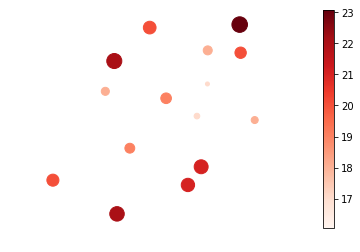

In [184]:
G = nx.generators.directed.gn_graph(16)

# G.add_edge('hola', '2')
pos = nx.layout.spring_layout(G)
sizes = [x.conf for x in reglas]

size_min = min([x.conf for x in reglas])
size_max = max([x.conf for x in reglas])
rango_size = (size_max - size_min) * 100

node_sizes = [int(size_min + rango_size * i) for i in range(len(G))]
M = G.number_of_nodes()


lift_min = min([x.lift for x in reglas])
lift_max = max([x.lift for x in reglas])
rango = (lift_max - lift_min) / M
edge_colors = [lift_min + int(rango*i) for i in range(2, M + 2)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=edge_colors, 
                              cmap=plt.cm.Reds)
# edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
#                                arrowsize=20, edge_color='black', width=0.5)

canciones = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=edge_colors, 
                               cmap=plt.cm.Reds)

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Reds)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()